# Urine based health report

# Load data and dependencies

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import pickle
import datetime as dt
from datetime import datetime, timedelta
import statistics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [73]:
data = pd.read_csv('../data/diabetes.csv').copy()
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Model the probability of diabetes logistic regression model

We focus only Age, BMI and Outcome as that is the only data that will be available to us.

In [74]:
X = np.array(data[['Age', 'BMI']])
y = np.array(data['Outcome'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
model = LogisticRegression()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       113
           1       0.32      0.27      0.29        41

    accuracy                           0.66       154
   macro avg       0.54      0.53      0.53       154
weighted avg       0.64      0.66      0.64       154



In [77]:
print(confusion_matrix(y_test, y_pred))

[[90 23]
 [30 11]]


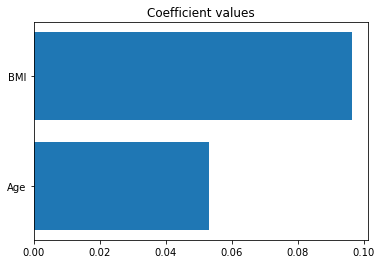

In [83]:
plt.figure(figsize=(6,4))
plt.barh(['Age', 'BMI'],model.coef_[0])
plt.title("Coefficient values")
plt.show()

In [84]:
pickle.dump(model, open('../models/model.sav', 'wb'))

In [90]:
model = pickle.load(open('../models/model.sav', 'rb'))

In [27]:
def find_age(dob):
    now = datetime.now()
    delta = now - dob
    seconds_in_year = 365.25*24*60*60
    age = delta.total_seconds() // seconds_in_year
    return age

def BMI(height, weight):
    bmi = weight/(height*height)
    return bmi

def diabetes_score(age, height, weight):
    model = pickle.load(open('../models/model.sav', 'rb'))
    
    bmi = BMI(height, weight)
    inp = np.array([age, bmi]).reshape(1, -1)
    
    out = model.predict_proba(inp)
    out = out[0][1]    
    return out

In [92]:
diabetes_score(57, 1.7, 90)

0.6223973381897838

## Urine color and pH based rule based model

In [6]:
urine_color_dict = {
    'Clear':0,
    'Pale Yellow':1,
    'Yellow':2,
    'Dark Yellow':3,
    'Honey':4,
    'Brown':5
}

def color_score(color):
    score = urine_color_dict[color]
    return score/5

In [104]:
color_score('Dark Yellow')

0.6

In [127]:
def ph_score(ph):
    if 4.5<ph<8:
        score = abs(ph-7)
        score = score/2.5
    else:
        score = 1
    return score

In [137]:
ph_score(6)

0.4

## Risk Score

$$P(Risk) = \frac{P(Diabetes)+ColorScore+pHScore}{4}$$

In [170]:
def risk_score(age, height, weight, urine_color, urine_ph):
    diabetes =  diabetes_score(age, height, weight)
    color = color_score(urine_color)
    ph = ph_score(urine_ph)
    
    score = (diabetes + color + ph) / 3
    return score

In [171]:
risk_score(67, 1.77, 95, 'Yellow', 4.7)

0.6804864229465734

In [1]:
def segment_risk_score(age):
    if 0<=age<40:
        score = 0.0976
    elif 40<age<60:
        score = 0.3847
    else:
        score = 0.725
    return score

## Gauge meters

In [217]:
def risk_gauge(risk, segment=False):
    fig = go.Figure()

    if segment:
        title = 'Segment Lifestyle Risk'
    else:
        title = 'Lifestyle Risk'
    
    fig.add_trace(go.Indicator(
        mode = 'gauge+number',
        value = risk*100,
        title = {'text':title},
        gauge={'axis': {'range':[0,100]},
               'bar':{'color':'#4D96FF', 'thickness':0.17},
               'steps':[
                    {'range':[0,33.33], 'color':'#6BCB77'},
                    {'range':[33.33,66.66], 'color':'#FFD93D'},
                    {'range':[66.66,100], 'color':'#FF6B6B'}
              ]
              }
    ))
    
    return fig

In [218]:
fig = risk_gauge(risk_score(67, 1.77, 95, 'Yellow', 4.7))
fig.show()

## Water vs pH graph

In [362]:
def water_ph_plot(time_list, ph_list, water_list):
    fig = make_subplots(specs=[[{'secondary_y':True}]])
    fig.update_layout(title='Water intake vs. Urine pH')


    fig.add_trace(go.Bar(x=time_list, y=water_list, name='Glasses of water',
                         marker={'color':'#1b95e0'}, text=water_list), secondary_y=True)
    fig.add_trace(go.Scatter(x=time_list, y=ph_list, 
                             mode='lines+markers', name='Urine pH level',
                             marker={'color':'#FFA500'}), secondary_y=False)
    fig.add_trace(go.Scatter(x=time_list, y=[8 for i in range(10)], mode='lines',
                            line={'dash':'dash', 'color':'blue'},
                            name='Upper healthy pH limit (Alkaline)'))
    fig.add_trace(go.Scatter(x=time_list, y=[4.5 for i in range(10)], mode='lines',
                            line={'dash':'dash', 'color':'red'},
                            name='Lower healthy pH limit (Acidic)'))


    fig.update_yaxes(title_text='Urine pH level', range=[1,14], 
                     showgrid=True, secondary_y=False)
    fig.update_yaxes(range=[0,5], 
                     showgrid=False, tickvals=[],
                     secondary_y=True)
    fig.update_xaxes(title_text='Time')

    return fig

In [363]:
fig = water_ph_plot(time_list, ph_level, water)
fig.show()

## pH information

In [51]:
def ph_info(water_dict):
    time_list = []
    ph_list = [7 for i in range(24)]
    water_list = [0 for i in range(24)]
    
    time = min(water_dict.keys())
    time = datetime(100, 1, 1, time.hour, time.minute, time.second)
    time -= timedelta(hours=1)
    time = time.time()
    
    for i in range(24):
        time_list.append(time)
        last_time = time
        time = datetime(100, 1, 1, time.hour, time.minute, time.second)
        time += timedelta(hours=1)
        time = time.time()
        
        ph_list = ph_list[:i] + [j-0.25 for j in ph_list[i:]]
        
        for key in water_dict.keys():
            if last_time<=key<time:
                last_time = key
                time_list[i] = key
                water_list[i] = water_dict[key]
                ph_list[i:] = [7 for k in range(len(ph_list[i:]))]
        
    return time_list, ph_list, water_list

In [ ]:
water_dict ={
    dt.time(12,0):3,
    dt.time(9,11):2,
    dt.time(8,0):1
}

urine

In [53]:
ph_info(water_dict)

([datetime.time(7, 0),
  datetime.time(8, 0),
  datetime.time(9, 11),
  datetime.time(10, 0),
  datetime.time(11, 0),
  datetime.time(12, 0),
  datetime.time(13, 0),
  datetime.time(14, 0),
  datetime.time(15, 0),
  datetime.time(16, 0),
  datetime.time(17, 0),
  datetime.time(18, 0),
  datetime.time(19, 0),
  datetime.time(20, 0),
  datetime.time(21, 0),
  datetime.time(22, 0),
  datetime.time(23, 0),
  datetime.time(0, 0),
  datetime.time(1, 0),
  datetime.time(2, 0),
  datetime.time(3, 0),
  datetime.time(4, 0),
  datetime.time(5, 0),
  datetime.time(6, 0)],
 [6.75,
  7,
  7,
  6.75,
  6.5,
  7,
  6.75,
  6.5,
  6.25,
  6.0,
  5.75,
  5.5,
  5.25,
  5.0,
  4.75,
  4.5,
  4.25,
  4.0,
  3.75,
  3.5,
  3.25,
  3.0,
  2.75,
  2.5],
 [0, 1, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Urine Color based recommendation

In [ ]:
def color_based_recommendation(urine_color):
    if urine_color == 'Clear':
        rec = "Doing Great! You are well hydrated."
    elif urine_color == 'Pale Yellow':
        rec = "Doing ok. You're probably well hydrated. Drink water as normal."
    elif urine_color == 'Yellow':
        rec = "You're just fine. You could stand to drink a little water now, maybe a small glass of water."
    elif urine_color == 'Dark Yellow':
        rec = "Drink about 1/2 bottle of water (250 ml) within the hour, or drink a whole bottle (500 ml) of water if you're outside and/or sweating."
    elif urine_color == 'Honey':
        rec = "Drink about 1/2 bottle of water (250 ml) right now, or drink a whole bottle (500 ml) of water if you're outside and/or sweating."
    elif urine_color == 'Brown':
        rec = 'Drink 2 bottles of water right now (1000 ml).If your urine is darker than this and/or red, then dehydration may not be your problem.See a doctor.'
    else:
        rec = 'Please consult a docter.'
        
    return rec

In [158]:
def urine_based_recommendation(urine_ph):
    if 0<=urine_ph<4.5:
        rec = "Something is severely wrong. Your body is dangerously acidic; please see a doctor right away."
    elif 4.5<=urine_ph<6:
        rec = "This is a danger zone; your body is too acidic; drastic dietary and lifestyle changes are advised. Please see a doctor."
    elif 6<=urine_ph<6.5:
        rec = 'Consider dietary and lifestyle changes to improve the pH of your body.'
    elif 6.5<=urine_ph<6.7:
        rec = "Consider slight dietary adjustments to bring your pH back up to where it should be."
    elif 6.7<=urine_ph<7.25:
        rec = 'Congratulations! Keep up the good work by maintaining an alkalising lifestyle.'
    elif 7.25<=urine_ph<8:
        rec = "WHile not uncommon, this is not healthy."
    else:
        rec = 'Something is severely wrong. Your body is dangerously alkaline; please see a doctor right away.'
        
    return rec

## pH colorbar

In [156]:
def ph_chart(urine_ph):
    fig, ax = plt.subplots(figsize=(1, 6))
    fig.suptitle('Urine pH Scale')

    cmap = mpl.colors.ListedColormap(['#fe1321', '#fe531a', '#ffa400', 
                                      '#ffcc01', '#dbe000', '#6ed700', 
                                      '#00b601', '#038503', '#00a654', 
                                      '#00c1b9', '#008bca', '#014bca', 
                                      '#3421b9', '#480da7', '#3e0890'])

    bounds = [i for i in range(15)]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    boundaries=bounds,
                                    norm=norm,
                                    ticks=bounds,
                                    orientation='vertical')
    
    ax.annotate("Your Urine pH", xy=(0, urine_ph), xytext=(-2, urine_ph),
            arrowprops=dict(arrowstyle="->"))
    ax.annotate("Upper healthy pH limit", xy=(0, 8), xytext=(-3, 8),
            arrowprops=dict(arrowstyle="->"), c='b')
    ax.annotate("Lower healthy pH limit", xy=(0, 4.5), xytext=(-3, 4.5),
            arrowprops=dict(arrowstyle="->"), c='r')

    cbar.ax.set_yticklabels(['acidic']+[str(i) for i in range(1,14)]+['alkaline'])
    
    
    return fig

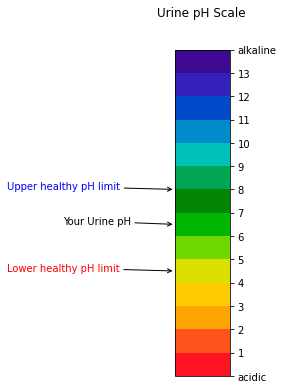

In [157]:
fig = ph_chart(6.5)

# New functions

In [3]:
def avg_ph(ph_list):
    n = len(ph_list)
    avg = sum(ph_list) / n
    return avg

In [11]:
def avg_color(color_list):
    avg = statistics.mode(color_list)
    return avg

In [29]:
water_dict = {
    dt.time(1, 15): 2,
    dt.time(2, 0): 1,
    dt.time(7,5): 5
}

urine_ph_dict = {
    dt.time(0, 56): 7,
    dt.time(23, 0): 3.5,
    dt.time(14,5): 2.8
}

In [30]:
def ph_info(water_dict, urine_ph_dict):
    time_list = []
    ph_list = []
    water_list = []
    time_ = dt.time(0,0)

    for i in range(24):
        time_list.append(time_)
        time_ = datetime(100, 1, 1, time_.hour, time_.minute, time_.second)
        time_ += timedelta(hours=1)
        time_ = time_.time()
    
    time_list = time_list + list(water_dict.keys()) + list(urine_ph_dict.keys())
    time_list = list(set(time_list))
    time_list = sorted(time_list)

    
    ph = 7
    
    for key in time_list:
        # check urine_ph_dict
        if key in urine_ph_dict:
            ph = urine_ph_dict[key]
        else:
            if 1.5<=ph<=13.5:
                ph -= 0.25
        # check water_dict
        if key in water_dict.keys():
            water = water_dict[key]
            if ph+water<=7.25:
                ph += water
            else:
                ph = 7
        else:
            water = 0
        
        ph_list.append(ph)
        water_list.append(water)
        
    
    return time_list, ph_list, water_list

In [31]:
time_list, ph_list, water_list = ph_info(water_dict, urine_ph_dict)

In [32]:
len(time_list)

28

In [33]:
time_list

[datetime.time(0, 0),
 datetime.time(0, 56),
 datetime.time(1, 0),
 datetime.time(1, 15),
 datetime.time(2, 0),
 datetime.time(3, 0),
 datetime.time(4, 0),
 datetime.time(5, 0),
 datetime.time(6, 0),
 datetime.time(7, 0),
 datetime.time(7, 5),
 datetime.time(8, 0),
 datetime.time(9, 0),
 datetime.time(10, 0),
 datetime.time(11, 0),
 datetime.time(12, 0),
 datetime.time(13, 0),
 datetime.time(14, 0),
 datetime.time(14, 5),
 datetime.time(15, 0),
 datetime.time(16, 0),
 datetime.time(17, 0),
 datetime.time(18, 0),
 datetime.time(19, 0),
 datetime.time(20, 0),
 datetime.time(21, 0),
 datetime.time(22, 0),
 datetime.time(23, 0)]

In [34]:
ph_list

[6.75,
 7,
 6.75,
 7,
 7,
 6.75,
 6.5,
 6.25,
 6.0,
 5.75,
 7,
 6.75,
 6.5,
 6.25,
 6.0,
 5.75,
 5.5,
 5.25,
 2.8,
 2.55,
 2.3,
 2.05,
 1.7999999999999998,
 1.5499999999999998,
 1.2999999999999998,
 1.0499999999999998,
 0.7999999999999998,
 3.5]

In [35]:
water_list

[0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [47]:
def drink_water_recommendation(time_list, ph_list, water_list):
    rehydrate_time = []
    for i in range(len(time_list)):
        ph = ph_list[i]
        time = time_list[i]
        water = water_list[i]

        if water!=0:
            rehydrate_time = []
            last_water = time
            
        if ph<=4.5 or ph>=8:
            rehydrate_time.append(time)
        else:
            pass
        
    if rehydrate_time == []:
        last_water = datetime(100, 1, 1, last_water.hour, last_water.minute, last_water.second)
        last_water += timedelta(hours=3)
        last_water = last_water.time()
        rehydrate_time = [last_water]
        rec_time = rehydrate_time[0].strftime('%I:%M %p')
        rec =f"It is advised that you drink water and rehydrate before {rec_time}."
    elif rehydrate_time[0]==last_water:
        rec_time = last_water.strftime('%I:%M %p')
        rec = f"You did not drink enough water the last time drank water (at {rec_time}), it is advised you drink more water immediately."
    else:
        rec_time = rehydrate_time[0].strftime('%I:%M %p')
        rec =f"It is advised that you drink water and rehydrate before {rec_time}."

    return rec 

In [48]:
drink_water_recommendation(time_list, ph_list, water_list)

[datetime.time(14, 5),
 datetime.time(15, 0),
 datetime.time(16, 0),
 datetime.time(17, 0),
 datetime.time(18, 0),
 datetime.time(19, 0),
 datetime.time(20, 0),
 datetime.time(21, 0),
 datetime.time(22, 0),
 datetime.time(23, 0)]

In [7]:
def extreme_case_based_recommendation(time_list, ph_list):
    rec_time_list = []
    
    for i in range(len(time_list)):
        time = time_list[i]
        ph = ph_list[i]
        
        if ph<=4.6 or ph>=7.9:
            rec_time_list.append(time)
    
    rec = []
    for time in rec_time_list:
        if dt.time(6,0)<=time<dt.time(8,0):
            rec.append('early-morning')
        elif dt.time(8,0)<=time<dt.time(10,0):
            rec.append('mid-morning')
        elif dt.time(10,0)<=time<dt.time(12,0):
            rec.append('late-morning')
        elif dt.time(12,0)<=time<dt.time(14,0):
            rec.append('early-afternoon')
        elif dt.time(14,0)<=time<dt.time(16,0):
            rec.append('mid-afternoon')
        elif dt.time(16,0)<=time<dt.time(18,0):
            rec.append('late-afternoon')
        elif dt.time(18,0)<=time<dt.time(21,0):
            rec.append('evening')
        elif dt.time(21,0)<=time<=dt.time(23,59):
            rec.append('night')
        elif dt.time(0,0)<=time<dt.time(3,0):
            rec.append('late-night')
        elif dt.time(3,0)<=time<dt.time(6,0):
            rec.append('toward-morning')
        else:
            pass
    
    rec = list(set(rec))
    
    if len(rec)==0:
        return 'Good job drinking water throughout the day!'
    elif len(rec)==1:
        return f"""Your urine pH dropped below healthy levels during {rec[0]}, make sure to consciously drink water during {rec[0]}."""
    else:
        return f"""Your urine pH dropped below healthy levels during {", ".join(rec[:-1]) + ' and ' + rec[-1]}, make sure to consciously drink water during {", ".join(rec[:-1]) + ' and ' + rec[-1]}."""